In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import seaborn as sns
import statsmodels
import subprocess
import sys

import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

sys.path.append(os.path.dirname(os.getcwd()))
import UKBB_traits

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import config_readwrite as crw
import fet
import split_filename
import plot_params as pp

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import chr_functions

pp.fonts()

('sans-serif', 'Arial', 18)

# load config 

In [2]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

REGIONS = config["CIS_TRANS"]["regions"]
REGION_ANNOT = config["CIS_TRANS"]["regions_annotations"]
PEAK_MAPPING = config["REGION_PEAK_OVERLAP"]["regions"]

PATH =  config["UKBB"]["path"]
RE = config["UKBB"]["results"]


# functions 

In [3]:
def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #hue = hue,
            linewidth=2.5, 
            #order = order,
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


    #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

    ax.set_xlabel("")

    #ax.get_yaxis().ticker.LogLocator(base=2)

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio, log2-scaled",  # y label
        title = title,
        ylim=ylim)
    return fig, ax

def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

In [4]:
def format_df(df):
    """
    return df w/ formatted columns
        Log2 OR
        Log2 CI
    """
    df["FC_log2"] = np.log2(df["FoldChange"])
    df["ci_025_log2"] = np.log2(df["ci_025"])
    df["ci_975_log2"] = np.log2(df["ci_975"])
    
    # replace negative and positive infinity values
    df["ci_025_log2"] = df["ci_025_log2"].replace(-np.inf, -1)
    df["ci_975_log2"] = df["ci_975_log2"].replace(-np.inf, -1)
    df["ci_025_log2"] = df["ci_025_log2"].replace(np.inf, 1)
    
    # add an asterisks for sig. enrichments
    df["asterisks"] = ""
    df.loc[df["p-value"]<0.05, "asterisks"] = "*"
    
    df = df.loc[~df["trait"].str.contains("AGE_COMPLETE")]
    df["sid2"] = df["sid"] + "-"+ df["trait"]
    
    return df

In [77]:
def plot_summary_bar(table, order):
    for_plotting = pd.melt(table.T)

    fig, (ax, ax1) = plt.subplots(ncols =2, figsize=(8,4))
    
    # barplot
    sns.barplot(x="sid", y="value", data=for_plotting, ax=ax,
               order=order)
    ax.set(xlabel="",
          ylabel = "log2 fold change"

          )
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=60,
                       horizontalalignment="right")
    
    # boxplot
    sns.boxplot(x="sid", y="value", data=for_plotting, ax=ax1,
               notch = True, showfliers = False,
               order=order)
    ax1.set(ylabel="",
            
            ylim=(-1,1.2)
           )
    ax1.axhline(0, color = "grey", ls ="--")
    ax1.set_xticklabels(ax1.get_xticklabels(), 
                        rotation=60,
                        horizontalalignment="right")
    return fig

# load data 

In [5]:
fs = glob.glob(os.path.join(RE, "*LD_exp_uniq_nohla.tsv"))

In [6]:
results = {}
trait_d=UKBB_traits.trait_all_mapping()

for f in fs:
    path, filename, sid = split_filename.split_filename(f)
    
    trait = trait_d[sid.split("clean_LD_exp")[0]]

    df = pd.read_csv(f, sep = '\t')

    df["trait"]=trait

    df = df.loc[df["date_time"] !="date_time"] # clean up the dataframes. 
    
    float_cols = ["p-value", "FoldChange", "ci_025", "ci_975",  'StdDev',]
    df[float_cols] = df[float_cols].astype(float)

    df["ntotalvars_in_target"]=df["ntotalvars_in_target"].astype(int)
    
    df = format_df(df)
    
    results[trait] = df
    
    if len(df.loc[df["p-value"]<0.1])>0:
        print(trait, df.loc[df["p-value"]<0.1])

CHRONIC_LYMPHOID_LEUKEMIA     Observed  Expected     StdDev  FoldChange   p-value  \
3         23      13.0   6.434609    1.714286  0.096903   
7         42      28.0   8.482009    1.482759  0.088911   
9         49      28.0   9.117079    1.724138  0.039960   
10        25      10.0   5.262982    2.363636  0.029970   
13        97      60.0  12.554919    1.606557  0.012987   
14        97      69.0  13.551575    1.400000  0.044955   
15       161     110.0  15.252730    1.459459  0.005994   

                     date_time    ci_975    ci_025  iters  \
3   2022-08-08 13:11:12.031626  1.714286  1.828571   1000   
7   2022-08-08 13:11:18.803725  1.429803  1.482759   1000   
9   2022-08-08 13:11:19.513326  1.724138  1.781609   1000   
10  2022-08-08 13:11:19.320249  2.363636  2.560606   1000   
13  2022-08-08 13:11:38.441660  1.552098  1.606557   1000   
14  2022-08-08 13:11:43.661371  1.400000  1.419718   1000   
15  2022-08-08 13:11:57.821579  1.446192  1.472490   1000   

            

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


    Observed  Expected    StdDev  FoldChange   p-value  \
5         36      22.0  6.572399    1.608696  0.040959   
12        24      14.0  5.774461    1.666667  0.084915   
16         4       1.0  1.000879    2.500000  0.018981   
18        21      10.0  5.106758    2.000000  0.052947   

                     date_time    ci_975    ci_025  iters  \
5   2022-08-08 13:10:08.779626  1.535573  1.608696   1000   
12  2022-08-08 13:10:30.417179  1.666667  1.770833   1000   
16  2022-08-08 13:16:55.728707  0.000000  2.500000   1000   
18  2022-08-08 13:16:56.825775  2.000000  2.000000   1000   

                                             sid  \
5                         peaks-trans_only_nohla   
12  peaks-MM-active_HH-inactive_trans-only_nohla   
16        HH-active_MM-inactive_trans-only_nohla   
18    peaks-MM-active_HH-inactive_cis-only_nohla   

                                       target  ntotalvars_in_target  \
5   phecode-070.3-both_sexesclean_LD_exp_uniq                 24801   


ECZEMA     Observed  Expected     StdDev  FoldChange   p-value  \
0          8       3.0   2.145417    2.250000  0.044955   
5         24      15.0   4.315861    1.562500  0.044955   
9         46      31.0   5.855816    1.468750  0.012987   
18       315     255.0  27.066992    1.234375  0.032967   

                     date_time    ci_975    ci_025  iters  \
0   2022-08-08 12:45:46.494289  2.250000  2.250000   1000   
5   2022-08-08 12:46:07.095623  1.458333  1.562500   1000   
9   2022-08-08 12:46:33.601480  1.421371  1.468750   1000   
18  2022-08-08 13:39:53.808861  1.219738  1.243944   1000   

                                      sid  \
0    MM-active_HH-inactive_cis-only_nohla   
5   MM-active_HH-inactive_cis+trans_nohla   
9                         cis+trans_nohla   
18                  peaks-cis+trans_nohla   

                                               target  ntotalvars_in_target  \
0   categorical-20002-both_sexes-1452clean_LD_exp_...                 53112   
5   cat

In [7]:
df = pd.concat(results.values())

df = df.loc[df["sid"].str.contains("peak")]


df.head()

,Observed,Expected,StdDev,FoldChange,p-value,date_time,ci_975,ci_025,iters,sid,target,ntotalvars_in_target,trait,FC_log2,ci_025_log2,ci_975_log2,asterisks,sid2
0,27,18,7.136475,1.473684,0.183816,2022-08-08 13:11:08.459459,1.473684,1.547368,1000,peaks-MM-active_HH-inactive_trans-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.559427,0.629817,0.559427,,peaks-MM-active_HH-inactive_trans-only_nohla-C...
3,23,13,6.434609,1.714286,0.096903,2022-08-08 13:11:12.031626,1.714286,1.828571,1000,peaks-MM-active_HH-inactive_cis-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.777608,0.870717,0.777608,,peaks-MM-active_HH-inactive_cis-only_nohla-CHR...
5,40,32,9.382233,1.242424,0.371628,2022-08-08 13:11:18.721800,1.203598,1.278966,1000,peaks-conserved_active.regions_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.313158,0.354978,0.267354,,peaks-conserved_active.regions_nohla-CHRONIC_L...
7,42,28,8.482009,1.482759,0.088911,2022-08-08 13:11:18.803725,1.429803,1.482759,1000,peaks-cis_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.568284,0.568284,0.515816,,peaks-cis_only_nohla-CHRONIC_LYMPHOID_LEUKEMIA
9,49,28,9.117079,1.724138,0.039960,2022-08-08 13:11:19.513326,1.724138,1.781609,1000,peaks-trans_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.785875,0.833181,0.785875,*,peaks-trans_only_nohla-CHRONIC_LYMPHOID_LEUKEMIA


# plot data

In [8]:
# make sure there are not any duplicate traits w/ duplicate values. 
t = df.groupby("sid2")["trait"].count().reset_index()
inspect = t.loc[t.trait>1, "sid2"]

drop_index = df.loc[df.sid2.isin(inspect)].index[::2]

df = df.drop(drop_index)

df.head()

,Observed,Expected,StdDev,FoldChange,p-value,date_time,ci_975,ci_025,iters,sid,target,ntotalvars_in_target,trait,FC_log2,ci_025_log2,ci_975_log2,asterisks,sid2
0,27,18,7.136475,1.473684,0.183816,2022-08-08 13:11:08.459459,1.473684,1.547368,1000,peaks-MM-active_HH-inactive_trans-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.559427,0.629817,0.559427,,peaks-MM-active_HH-inactive_trans-only_nohla-C...
3,23,13,6.434609,1.714286,0.096903,2022-08-08 13:11:12.031626,1.714286,1.828571,1000,peaks-MM-active_HH-inactive_cis-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.777608,0.870717,0.777608,,peaks-MM-active_HH-inactive_cis-only_nohla-CHR...
5,40,32,9.382233,1.242424,0.371628,2022-08-08 13:11:18.721800,1.203598,1.278966,1000,peaks-conserved_active.regions_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.313158,0.354978,0.267354,,peaks-conserved_active.regions_nohla-CHRONIC_L...
7,42,28,8.482009,1.482759,0.088911,2022-08-08 13:11:18.803725,1.429803,1.482759,1000,peaks-cis_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.568284,0.568284,0.515816,,peaks-cis_only_nohla-CHRONIC_LYMPHOID_LEUKEMIA
9,49,28,9.117079,1.724138,0.039960,2022-08-08 13:11:19.513326,1.724138,1.781609,1000,peaks-trans_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.785875,0.833181,0.785875,*,peaks-trans_only_nohla-CHRONIC_LYMPHOID_LEUKEMIA


# heatmaps

In [105]:
# dictionary for sorting terms by activity category

order=[

        'trans_only',
        'cis_only',
        'cis+trans',
        'conserved_active.regions',

        'HH-active_MM-inactive_trans-only',
        'HH-active_MM-inactive_cis-only',
        'HH-active_MM-inactive_cis+trans',

        'MM-active_HH-inactive_trans-only',
        'MM-active_HH-inactive_cis-only',
        'MM-active_HH-inactive_cis+trans'
        ]

cross_walk = {}
for i, o in enumerate(order):
    cross_walk[o]=i

# add column labeling the categories
df["sid3"] = ""
for k, v in cross_walk.items():
    df.loc[df["sid"] == k, "sid3"]=v

In [14]:
def pivot_table(df, val):
    """
    pivot the table and fill w/ values
    
    round table to 2 decimal points
    """
    table = pd.pivot(data = df, 
                     columns = ["trait", "ntotalvars_in_target"] , 
                     index = ["sid", "sid3"] , 
                     values = val)
    
    table = table.round(2)
    
    return table

In [101]:
table = pivot_table(df, "FC_log2")
ptable =  pivot_table(df ,"p-value") 
ctable = pivot_table(df, "Observed")


list(table)

[('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
 ('BILIARY_CIRROHSIS', 22108),
 ('HAY_FEVER_ALLERGIC_RHINITIS', 91521),
 ('WBC_COUNT', 563041),
 ('MS', 71646),
 ('CANCER_OTHER_LYMPHOID_HISTIOCYTIC', 29289),
 ('LYMPHOCYTE_COUNT', 631201),
 ('UC', 49484),
 ('COVID-19_HOSP', 11560),
 ('VIRAL_HEPC', 24801),
 ('TOBACCO_SMOKING_MOST_ALL_DAY', 17203),
 ('VIRAL_INFECTION', 28703),
 ('BREAST_CANCER', 72256),
 ('LYMPHOID_LEUKEMIA', 27474),
 ('NEUTROPHIL_PERCENTAGE', 465498),
 ('ASTHMA', 185347),
 ('HYPOTHYROIDISM', 168935),
 ('SCZ', 23531),
 ('MEAN_PLATELET_VOLUME', 946121),
 ('SLE', 46300),
 ('RA', 77191),
 ('ECZEMA', 53112),
 ('NHL', 37994),
 ('CROHNS', 27834),
 ('CELIAC_DISEASE', 136177),
 ('ALZ', 22850),
 ('PLATELET_COUNT', 854496),
 ('ATOPIC_DERMATITIS', 23246)]

In [102]:
new_tableorder = [
('ASTHMA', 185347),
('CELIAC_DISEASE', 136177),

('ECZEMA', 53112),
('HAY_FEVER_ALLERGIC_RHINITIS', 91521),
('MS', 71646),
('RA', 77191),
('SLE', 46300),
('UC', 49484),

('ATOPIC_DERMATITIS', 23246),
('BILIARY_CIRROHSIS', 22108),
('CROHNS', 27834),
('HYPOTHYROIDISM', 168935),

('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
('LYMPHOID_LEUKEMIA', 27474),
('CANCER_OTHER_LYMPHOID_HISTIOCYTIC', 29289),

('VIRAL_HEPC', 24801),    
('VIRAL_INFECTION', 28703),
('COVID-19_HOSP', 11560),
 ('LYMPHOCYTE_COUNT', 631201),
('NEUTROPHIL_PERCENTAGE', 465498),
('MEAN_PLATELET_VOLUME', 946121),
 ('WBC_COUNT', 563041),
 ('PLATELET_COUNT', 854496),


('BREAST_CANCER', 72256),
('NHL', 37994),
('TOBACCO_SMOKING_MOST_ALL_DAY', 17203),
('ALZ', 22850),
('SCZ', 23531)

] 
table = table[new_tableorder]
ptable=ptable[new_tableorder]
ctable=ctable[new_tableorder]

## all of the data 

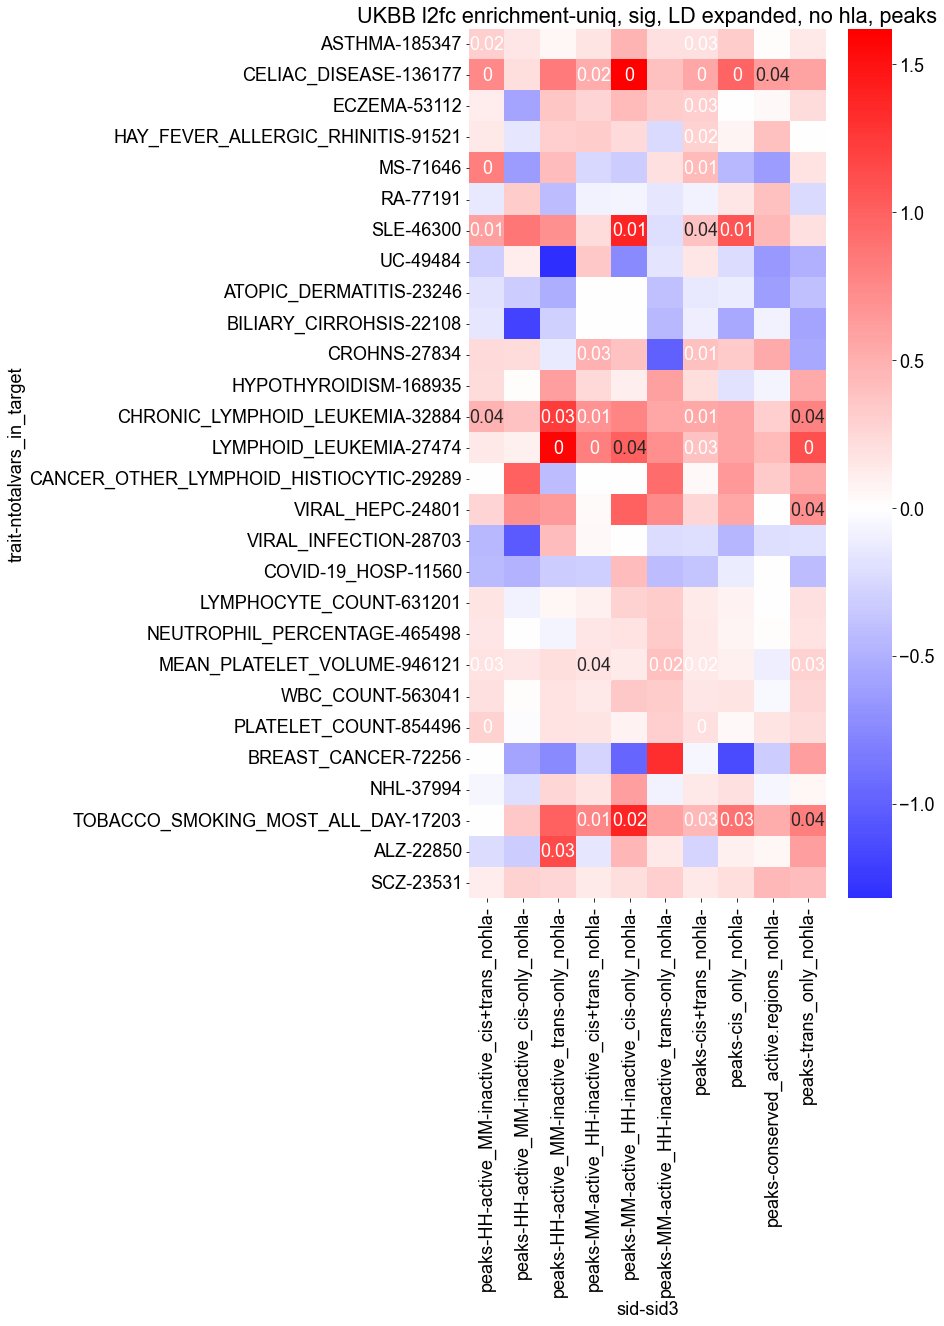

In [103]:
fig, ax = plt.subplots(figsize =(8,16))
sns.heatmap(table.T, cmap="bwr", center=0)
sns.heatmap(ptable.T,
            mask=ptable.T>=0.05, 
            #cmap="bwr", 
            center=0, alpha=0, annot=True, cbar=False)
plt.title("UKBB l2fc enrichment-uniq, sig, LD expanded, no hla, peaks")
out = os.path.join(RE, "UKBB_TRAITS_l2fc_heatmap-uniq-peaks-ALL_nohla.pdf")
plt.savefig(out, bbox_inches="tight")

## summary barplot for all traits (n=28 traits)

In [108]:
order = [

'peaks-cis_only_nohla',

'peaks-trans_only_nohla',
'peaks-cis+trans_nohla',
'peaks-conserved_active.regions_nohla',

'peaks-HH-active_MM-inactive_cis-only_nohla',
'peaks-HH-active_MM-inactive_trans-only_nohla',
'peaks-HH-active_MM-inactive_cis+trans_nohla',

'peaks-MM-active_HH-inactive_cis-only_nohla',
'peaks-MM-active_HH-inactive_trans-only_nohla',
'peaks-MM-active_HH-inactive_cis+trans_nohla',
]

## bar and box plots

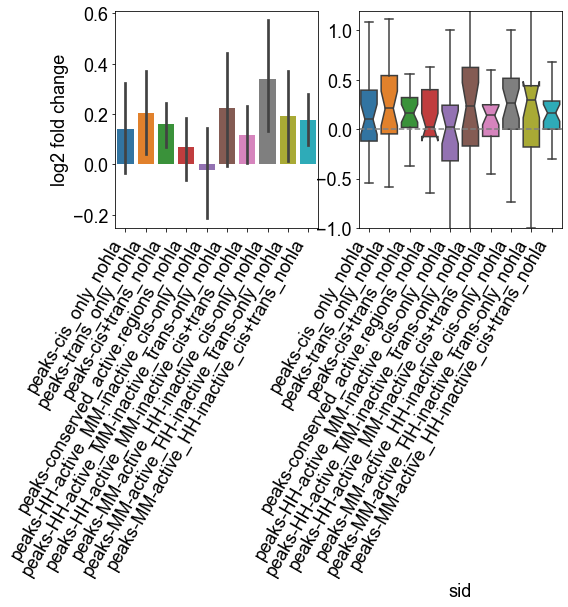

In [109]:
bar = plot_summary_bar(table, order)
out = os.path.join(RE, f"UKBB_TRAITS_l2fc_heatmap-uniq-peaksf_ALL_fig_nohla-BAR.pdf")
plt.savefig(out, bbox_inches="tight")

## all of the count data 

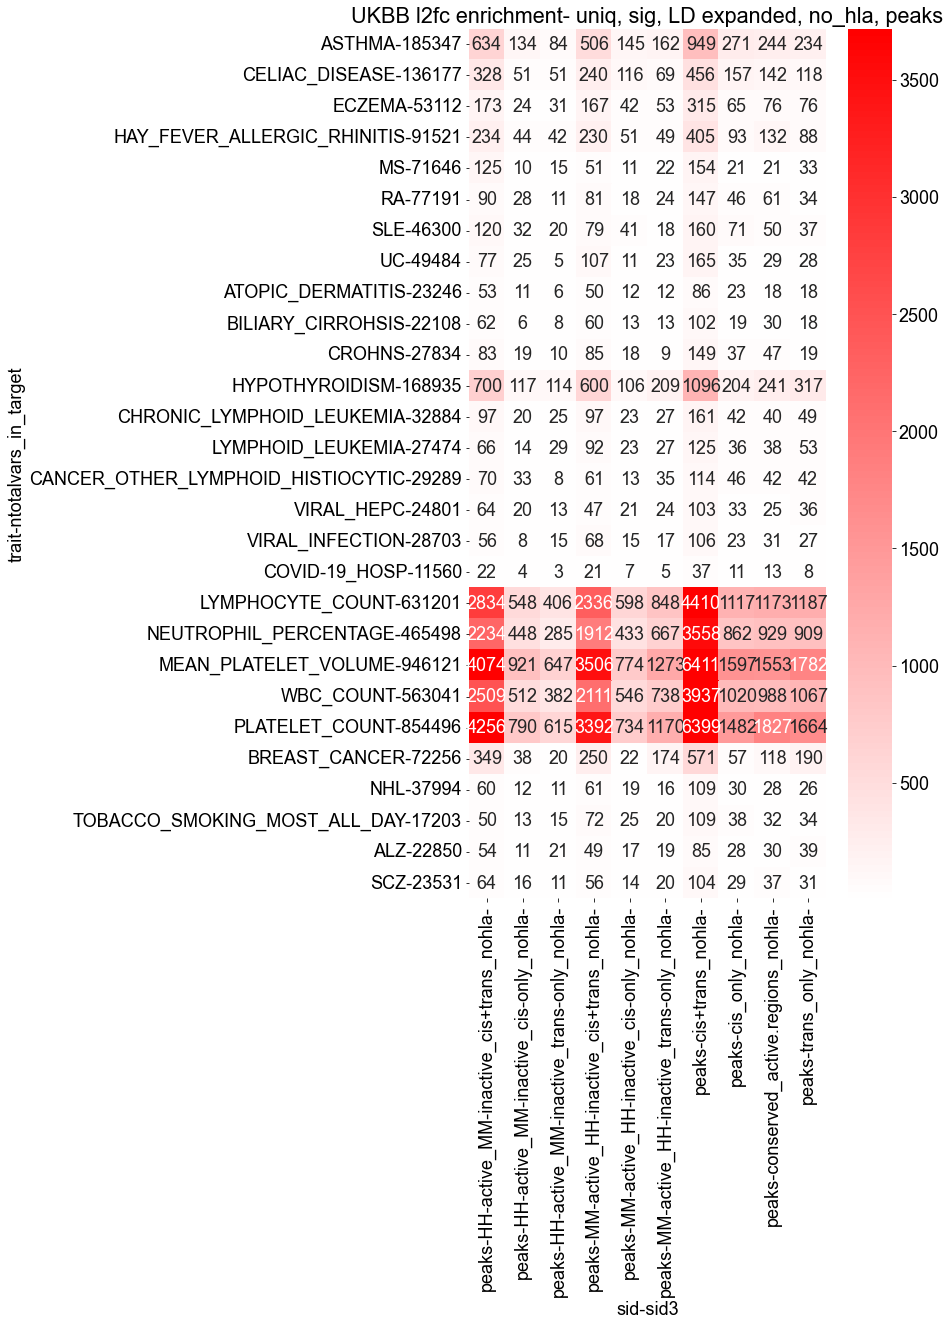

In [12]:
ctable = ctable.astype(int)

fig, ax = plt.subplots(figsize =(8,16))
sns.heatmap(ctable.T, cmap="bwr", center=0, annot =True, fmt="d", robust=True)

plt.title("UKBB l2fc enrichment- uniq, sig, LD expanded, no_hla, peaks")
out = os.path.join(RE, "UKBB_TRAITS_l2fc_heatmap-uniq-peaks-ALL_nohla_counts.pdf")
plt.savefig(out, bbox_inches="tight")

## data for figure 

In [98]:
fig_tableorder = [
('BILIARY_CIRROHSIS', 22108),
('ATOPIC_DERMATITIS', 23246),
('UC', 49484),
    ('MS', 71646),
('SLE', 46300),
('CELIAC_DISEASE', 136177),
    ('VIRAL_HEPC', 24801),    
('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
#('LYMPHOID_LEUKEMIA', 27474),

    ('HYPOTHYROIDISM', 168935),
    ('RA', 77191),
('CROHNS', 27834),
    ('HAY_FEVER_ALLERGIC_RHINITIS', 91521),

('ECZEMA', 53112),


('PLATELET_COUNT', 854496),
('ASTHMA', 185347),
('WBC_COUNT', 563041),


]



## separate groups to plot

In [86]:
sns.clustermap

<function seaborn.matrix.clustermap(data, *, pivot_kws=None, method='average', metric='euclidean', z_score=None, standard_scale=None, figsize=(10, 10), cbar_kws=None, row_cluster=True, col_cluster=True, row_linkage=None, col_linkage=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=0.2, colors_ratio=0.03, cbar_pos=(0.02, 0.8, 0.05, 0.18), tree_kws=None, **kwargs)>

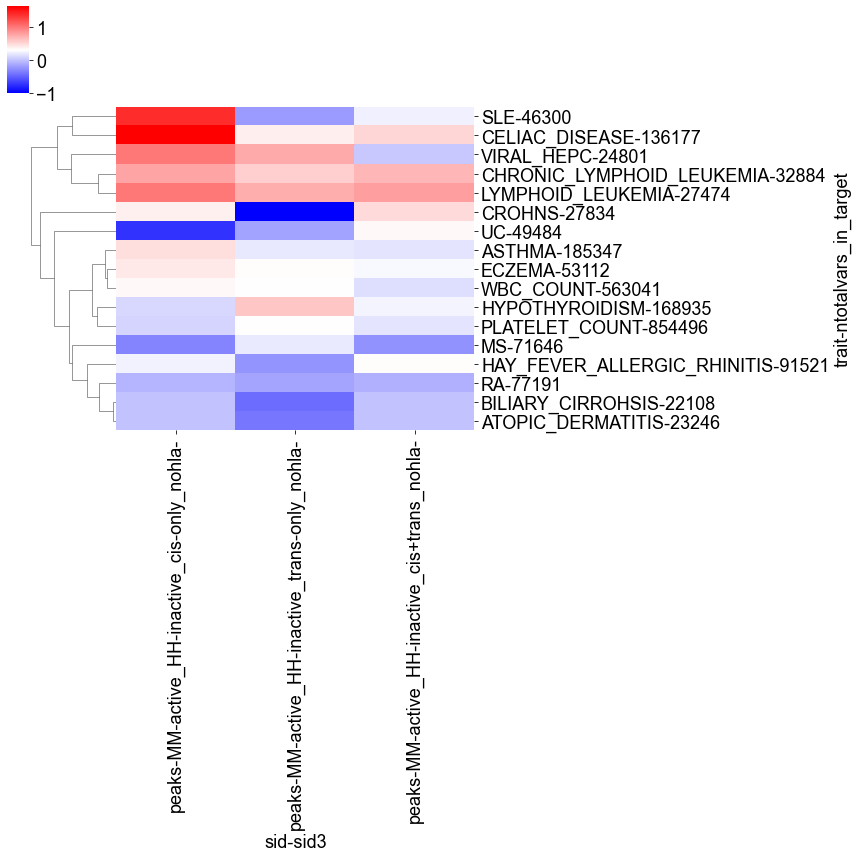

In [96]:
a = sns.clustermap(table.T, col_cluster=False, figsize=(12,12), 
                   #cbar=False,
                   cmap="bwr", square=True,
                  cbar_pos=(0.00, 0.9, 0.025, 0.1)
                  )

In [99]:
order_dict = {
    "all":[ "peaks-cis_only_nohla",  
    "peaks-trans_only_nohla",
    "peaks-cis+trans_nohla","peaks-conserved_active.regions_nohla"], 
    "fig":['peaks-cis_only_nohla',
    'peaks-trans_only_nohla',
    'peaks-cis+trans_nohla'],
    "HH":['peaks-HH-active_MM-inactive_cis-only_nohla',
    'peaks-HH-active_MM-inactive_trans-only_nohla',
    'peaks-HH-active_MM-inactive_cis+trans_nohla'],
    "MM":[
    'peaks-MM-active_HH-inactive_cis-only_nohla',
    'peaks-MM-active_HH-inactive_trans-only_nohla',
    'peaks-MM-active_HH-inactive_cis+trans_nohla',]
    }

    # dictionary for sorting terms by activity category

/home/fongsl/.local/lib/python3.6/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/fongsl/.local/lib/python3.6/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


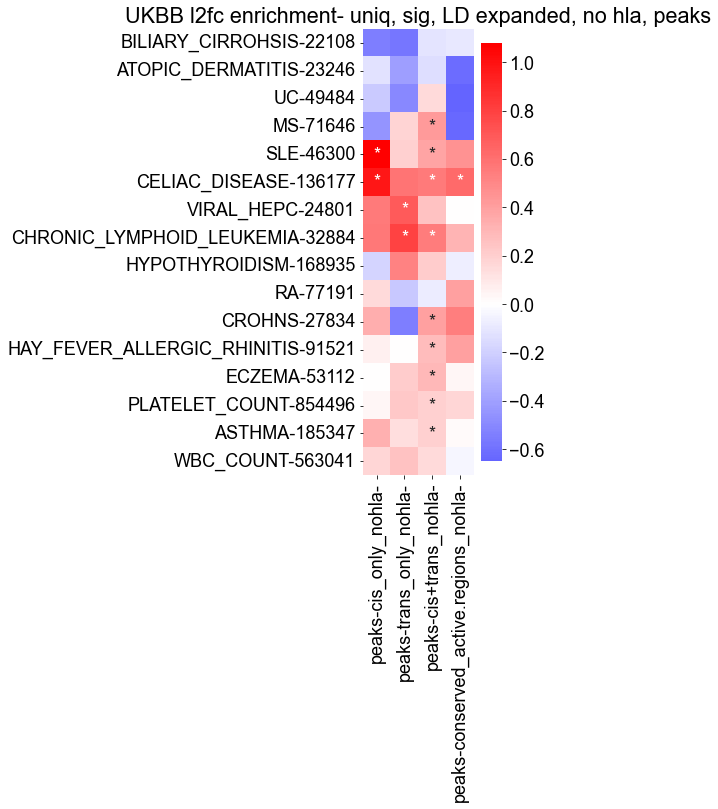

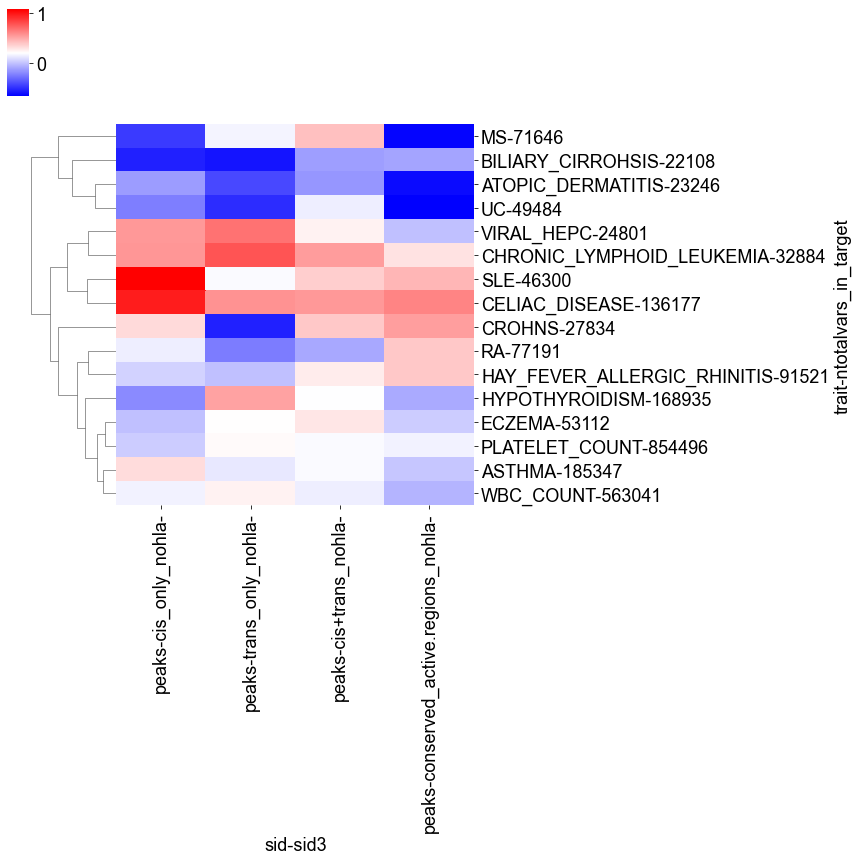

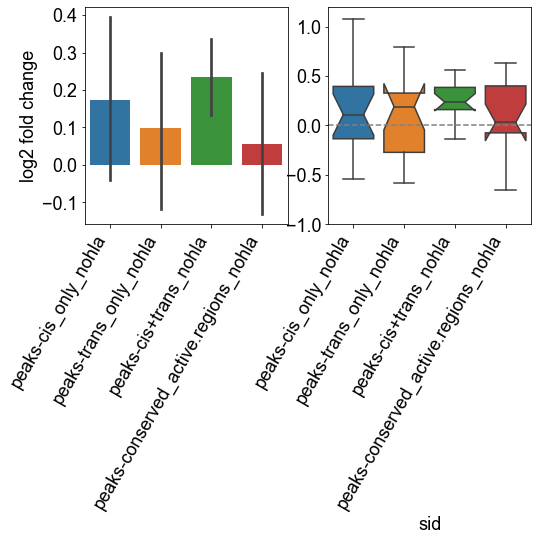

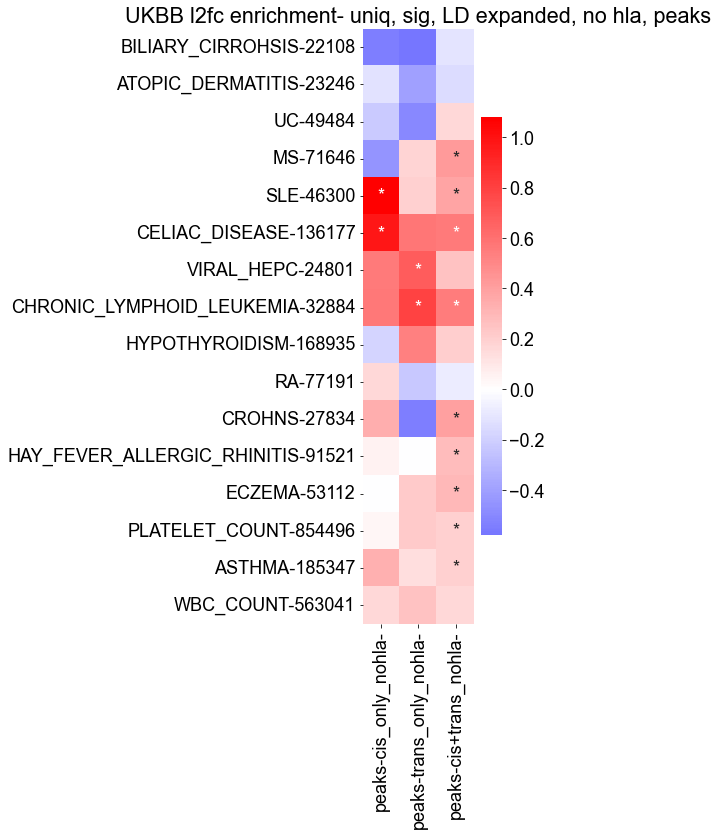

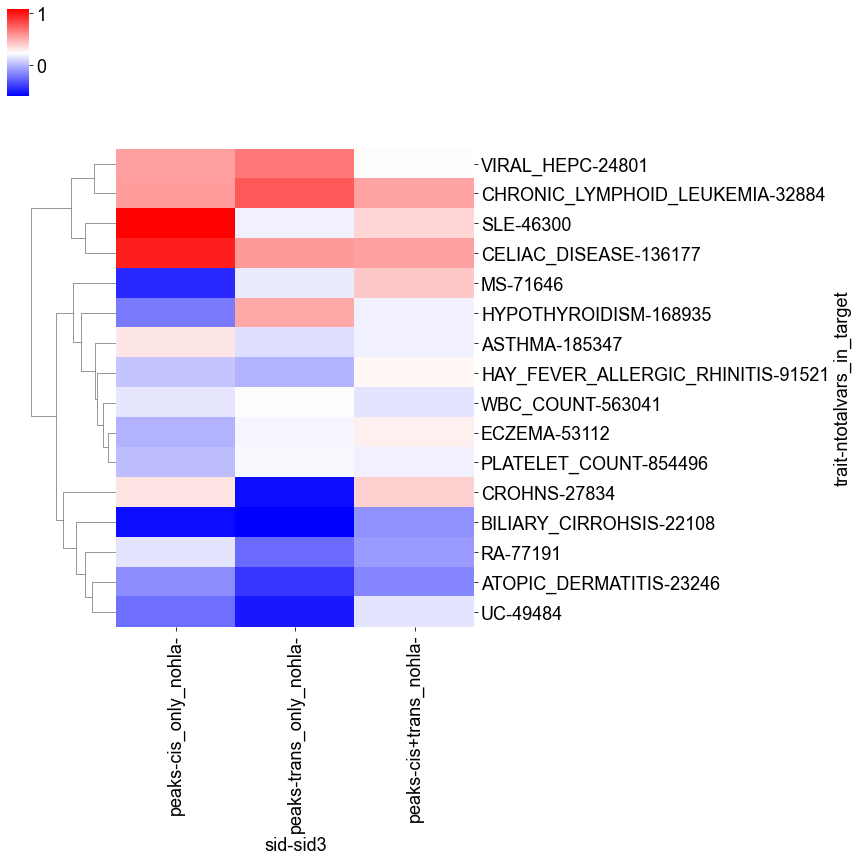

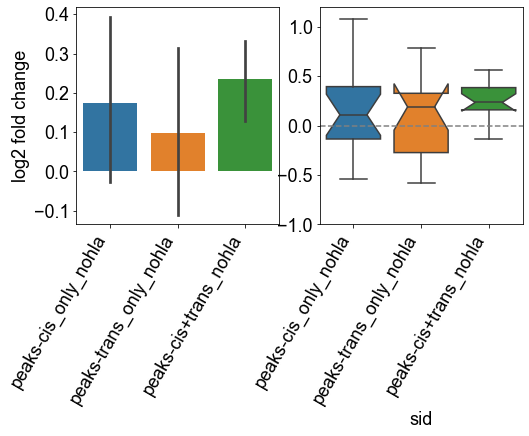

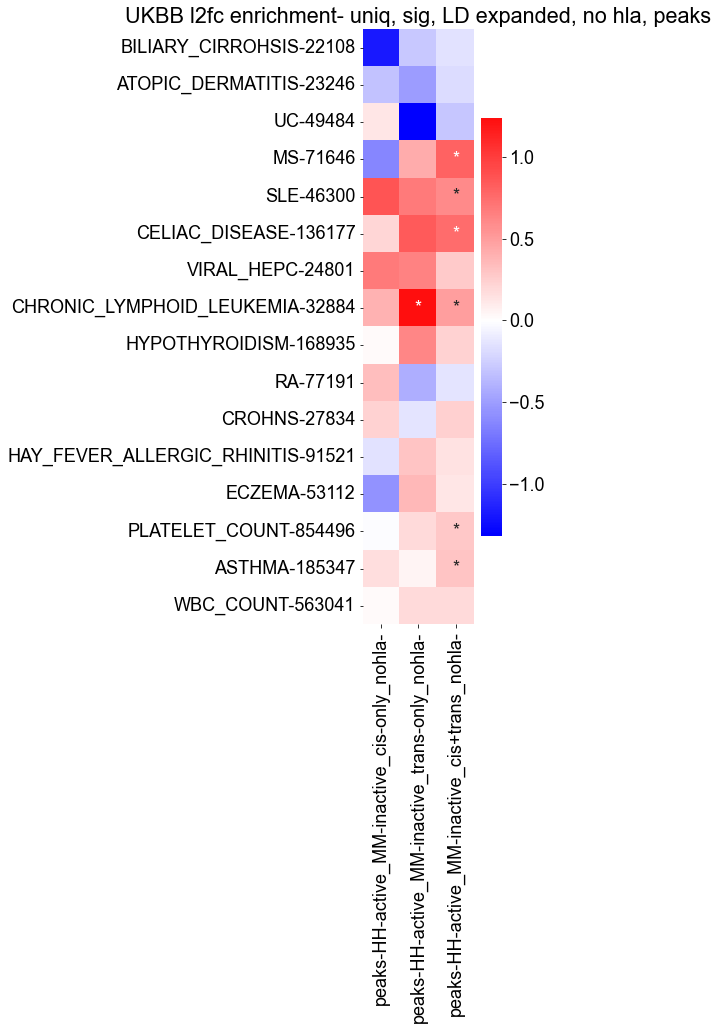

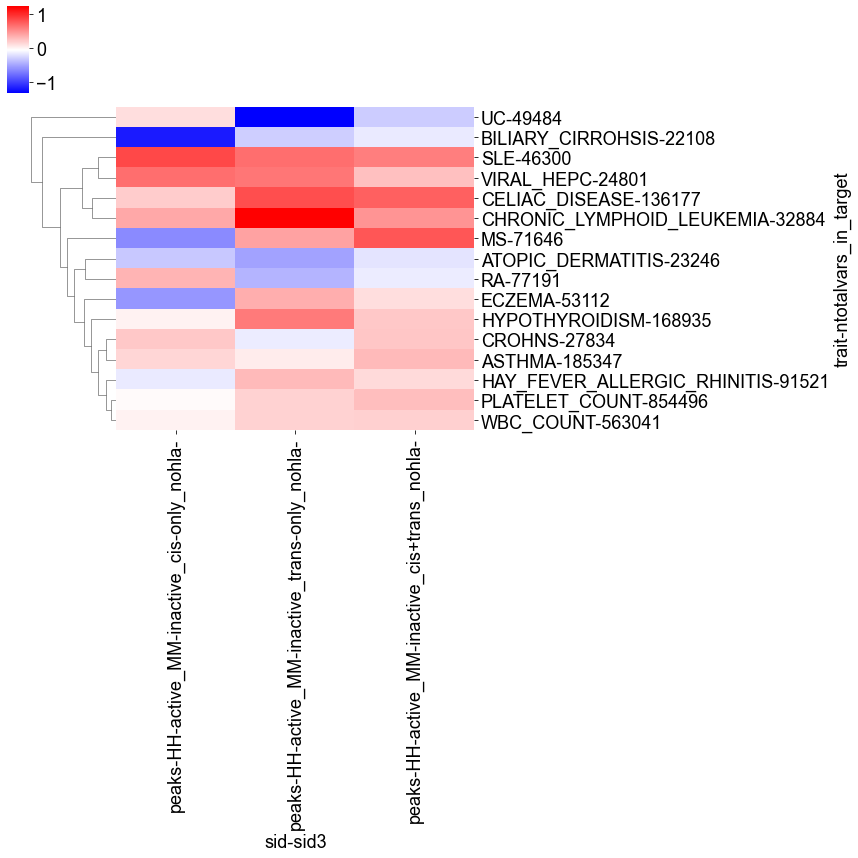

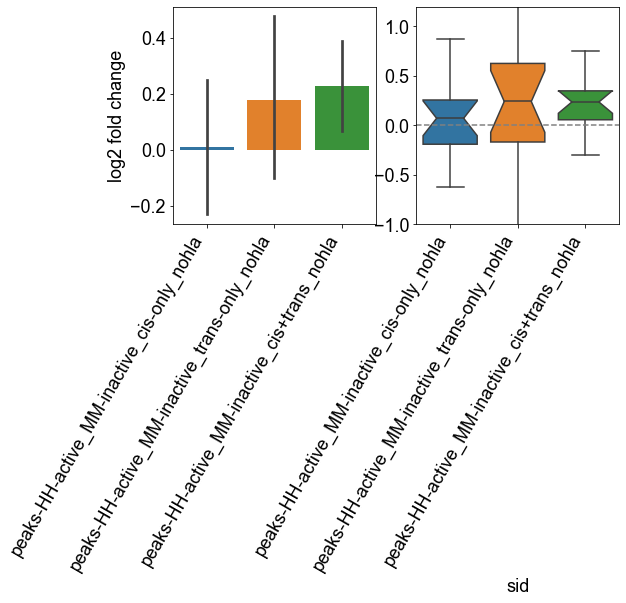

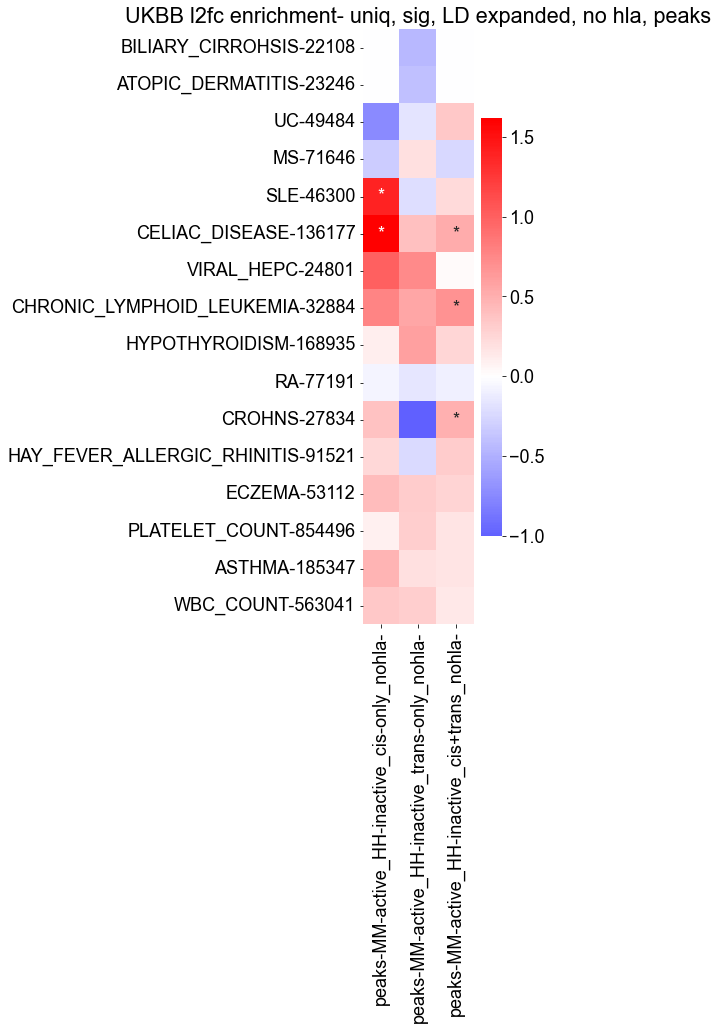

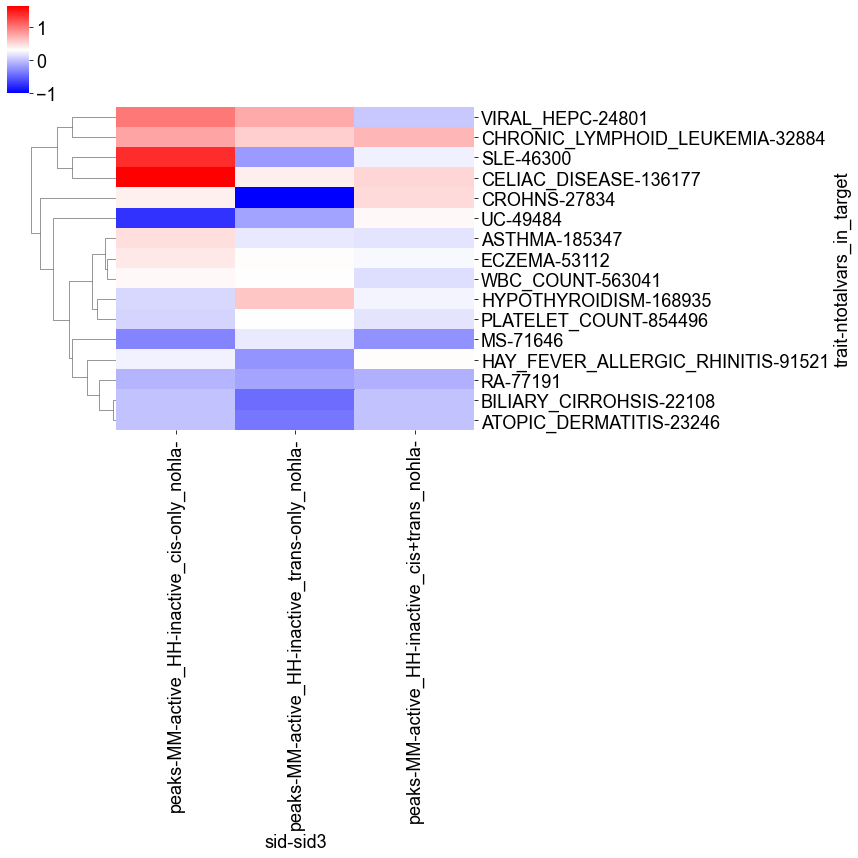

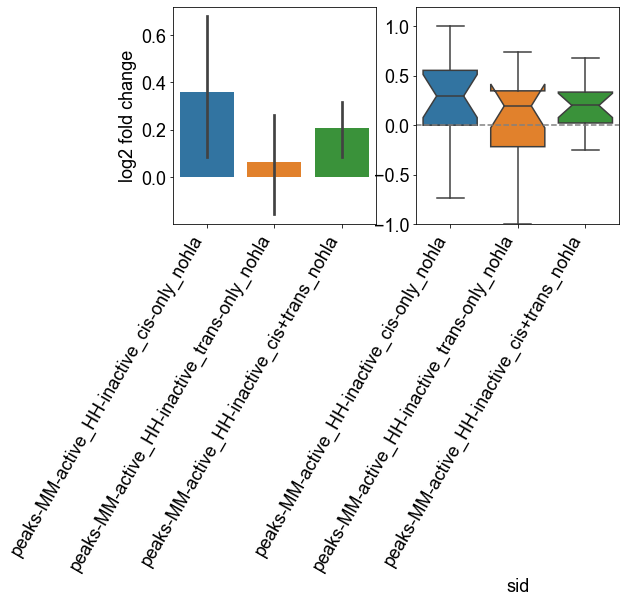

In [100]:
for name, order in order_dict.items():
    
    # subset data to specific regions
    test =  df.loc[df["sid"].isin(order)]

    # get data for plotting
    table = pivot_table(test, "FC_log2")
    ptable = pivot_table(test, "p-value")
    atable = pivot_table(test, "asterisks")

    # reorganize table order
    table = table.loc[order] 
    ptable = ptable.loc[order] # reorganize table order
    atable = atable.loc[order] # reorganize table order


    table = table[fig_tableorder]
    ptable = ptable[fig_tableorder]
    atable = atable[fig_tableorder]
    
    fig, ax = plt.subplots(figsize =(2.5,16))
    sns.heatmap(table.T, cmap="bwr", center=0, square=True, annot=atable.T, fmt="")

    ax.set(title="UKBB l2fc enrichment- uniq, sig, LD expanded, no hla, peaks",
           xlabel = "",
           ylabel = ""
          )
    
    out = os.path.join(RE, f"UKBB_TRAITS_l2fc_heatmap-uniq-peaksf_{name}_fig_nohla.pdf")
    plt.savefig(out, bbox_inches="tight")
    
    a = sns.clustermap(table.T, col_cluster=False, figsize=(12,12), 
                   #cbar=False,
                   cmap="bwr", 
                  cbar_pos=(0.00, 0.9, 0.025, 0.1)
                  )
    out = os.path.join(RE, f"UKBB_TRAITS_l2fc_heatmap-uniq-peaksf_{name}_fig_nohla-cluster.pdf")
    plt.savefig(out, bbox_inches="tight")
    
    bar = plot_summary_bar(table, order)
    out = os.path.join(RE, f"UKBB_TRAITS_l2fc_heatmap-uniq-peaksf_{name}_fig_nohla-BAR.pdf")
    plt.savefig(out, bbox_inches="tight")

In [ ]:
list(table.T)